🔍 تم اختيار العمود 'species' كهدف محتمل (قليل القيم الفريدة).
✅ استخدام العمود 'species' كعمود هدف.
⏳ بدء البحث الشبكي لضبط الهايبر باراميترز...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ أفضل إعدادات:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
🔹 الدقة المحسّنة: 0.5850

🔹 تقرير التصنيف:
              precision    recall  f1-score   support

        Lily       0.67      0.79      0.73        39
      Orchid       0.41      0.45      0.43        33
        Rose       0.50      0.50      0.50        40
   Sunflower       0.73      0.53      0.61        51
       Tulip       0.60      0.65      0.62        37

    accuracy                           0.58       200
   macro avg       0.58      0.59      0.58       200
weighted avg       0.60      0.58      0.58       200



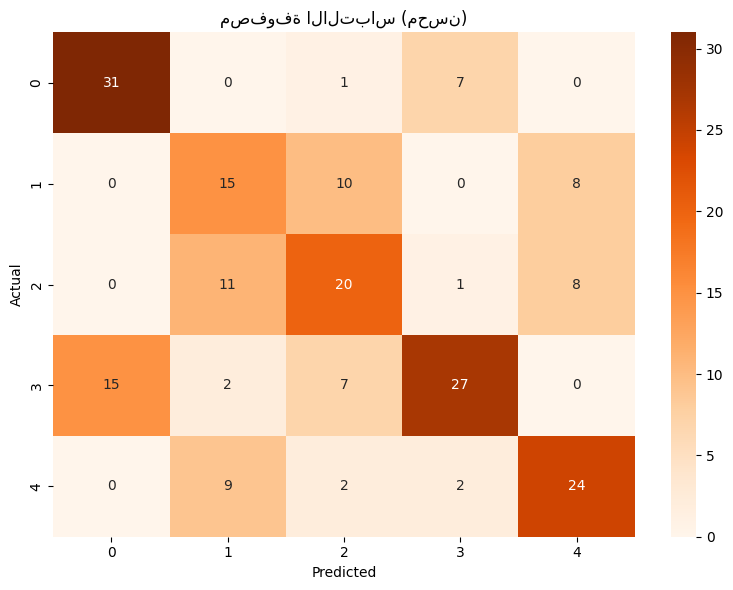

In [2]:
# 🔧 05 – Model Tuning

"""
الهدف:
تحسين أداء النموذج المختار باستخدام GridSearchCV و/أو RandomizedSearchCV
"""

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 📥 تحميل البيانات بشكل مرن عبر مسار نسبي
data_path = os.path.join('..', 'data', 'processed', 'clean_data.csv')
df = pd.read_csv(data_path)

# --- تحديد عمود الهدف بشكل أكثر ذكاء ---
target = None

# محاولة إيجاد عمود هدف مباشر
for col in df.columns:
    if col.lower() in ['target', 'label', 'y']:
        target = col
        print(f"🎯 تم التعرف على عمود الهدف تلقائيًا: '{target}'")
        break

# إذا لم يتم العثور، محاولة اختيار أول عمود عدد قيمه الفريدة أقل من 10 (مناسب للتصنيف غالبًا)
if target is None:
    possible_targets = [col for col in df.columns if df[col].nunique() <= 10]
    if possible_targets:
        target = possible_targets[0]
        print(f"🔍 تم اختيار العمود '{target}' كهدف محتمل (قليل القيم الفريدة).")
    else:
        print("⚠️ لم يتم العثور على عمود هدف واضح.")
        print("📋 الأعمدة الموجودة:")
        for c in df.columns:
            print(f" - {c}")
        # يمكن إلغاء التعليق أدناه لتمكين الإدخال اليدوي في بيئة تفاعلية
        # target = input("📝 من فضلك أدخل اسم العمود الهدف يدويًا: ").strip()
        raise Exception("🚨 يرجى تحديد عمود الهدف في البيانات.")

print(f"✅ استخدام العمود '{target}' كعمود هدف.")

# فصل السمات الرقمية فقط وملء القيم الناقصة
X = df.drop(columns=[target]).select_dtypes(include=['float64', 'int64']).fillna(0)
y = df[target]

if X.shape[1] == 0:
    raise Exception("🚫 لا توجد سمات رقمية قابلة للنمذجة.")

# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تحديد نوع المسألة: تصنيف أم انحدار
is_classification = y.nunique() <= 10

# إعداد النموذج الأساسي بناءً على نوع المهمة
model = RandomForestClassifier(random_state=42) if is_classification else RandomForestRegressor(random_state=42)

# شبكة الهايبر باراميترز لضبطها
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("⏳ بدء البحث الشبكي لضبط الهايبر باراميترز...")
search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy' if is_classification else 'r2',
    verbose=2
)
search.fit(X_train, y_train)

# أفضل نموذج بعد الضبط
best_model = search.best_estimator_
print("✅ أفضل إعدادات:")
print(search.best_params_)

# التنبؤ بالاختبار
y_pred = best_model.predict(X_test)

# 📊 تقييم النموذج بعد الضبط
if is_classification:
    acc = accuracy_score(y_test, y_pred)
    print(f"🔹 الدقة المحسّنة: {acc:.4f}\n")
    print("🔹 تقرير التصنيف:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('مصفوفة الالتباس (محسن)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix_tuned.png')
    plt.show()

else:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"🔹 RMSE: {rmse:.4f}\n🔹 R²: {r2:.4f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='teal')
    plt.title('Actual vs Predicted (محسن)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.savefig('regression_results_tuned.png')
    plt.show()
